# Proyecto

**Objetivo del Proyecto :** Análisis comparativo de algoritmos de clasificación, basados en lenguaje máquina, para la predicción de bancarrota, según datos financieros.

**Conjunto De Datos A Utilizar :**  Taiwanese Bankruptcy Prediction Data Set -
https://archive.ics.uci.edu/ml/datasets/Taiwanese+Bankruptcy+Prediction

**Algoritmo :** XGBoost Classifier - 
https://xgboost.readthedocs.io/en/latest/

## Path definition

In [1]:
# Si se traba conectado a drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
% cd /content/gdrive/MyDrive/Dataset

/content/gdrive/MyDrive/Dataset


In [1]:
% ls -lhtr

## Library imports

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from scipy.io import arff
import random
from collections import OrderedDict
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

## Dataset and labels, read and adaptation

In [ ]:
df_col = pd.read_csv('labels_bankruptcy.csv', sep=' ',names=['codes','Names'])
names_to_codes = dict(zip(df_col['Names'],df_col['codes'])) # this will serve later for brevity
codes_to_names = dict(zip(df_col['codes'],df_col['Names']))
cols = ['flag'] # add flag column
cols = cols + list(df_col['Names'])
df = pd.read_csv('TEJ_data.csv', encoding = "cp1252", names=cols, skiprows=1)
df.head(5)

,flag,Cost_of_Interest-bearing_Debt,Cash_Reinvestment_Ratio,Current_Ratio,Acid_Test,Interest_Expenses/Total_Revenue,Total_Liability/Equity_Ratio,Liability/Total_Assets,Interest-bearing_Debt/Equity,Contingent_Liability/Equity,Operating_Income/Capital,Pretax_Income/Capital,Working_Capital_to_Total_Assets,Quick_Assets/Total_assets,Current_Assets/Total_Assets,Cash/Total_Assets,Quick_Assets/Current_Liability,Cash/Current_Liability,Current_Liability_to_Assets,Operating_Funds_to_Liability,Inventory/Working_Capital,Inventory/Current_Liability,Current_Liabilities/Liability,Working_Capital/Equity,Current_Liabilities/Equity,Long-term_Liability_to_Current_Assets,Current_Liability_to_Current_Assets,One_if_Total_Liability_exceeds_Total_Assets;,Equity_to_Liability,Equity/Total_Assets,(Long-term_Liability+Equity)/Fixed_Assets,Fixed_Assets_to_Assets,Current_Liability_to_Liability,Current_Liability_to_Equity,Equity_to_Long-term_Liability,Liability_to_Equity,Degree_of_Financial_Leverage,Interest_Coverage_Ratio,Operating_Expenses/Net_Sales,(Research_and_Development_Expenses)/Net_Sales,...,Operating_Income_/Net_Sales,Pre-Tax_Income/Net_Sales,Net_Income/Net_Sales,Net_Non-operating_Income_Ratio,Net_Income-Exclude_Disposal_Gain_or_Loss/Net_Sales,EPS-Net_Income,Pretax_Income_Per_Share,Retained_Earnings_to_Total_Assets,Total_Income_to_Total_Expenses,Total_Expenses_to_Assets,Net_Income_to_Total_Assets,Gross_Profit_to_Sales,Net_Income_to_Stockholder's_Equity,One_if_Net_Income_is_Negative_for_the_Last_Two_Years;_Zero_Otherwise,(Inventory_+Accounts_Receivables)_/Equity,Total_Asset_Turnover,Accounts_Receivable_Turnover,Days_Receivable_Outstanding,Inventory_Turnover,Fixed_Asset_Turnover,Equity_Turnover,Current_Assets_to_Sales,Quick_Assets_to_Sales,Working_Capital_to_Sales,Cash_to_Sales,Cash_Flow_to_Sales,No-credit_Interval,Cash_Flow_from_Operating/Current_Liabilities,Cash_Flow_to_Total_Assets,Cash_Flow_to_Liability,CFO_to_Assets,Cash_Flow_to_Equity,Realized_Gross_Profit_Growth_Rate,Operating_Income_Growth,Net_Income_Growth,Continuing_Operating_Income_after_Tax_Growth,Net_Income-Excluding_Disposal_Gain_or_Loss_Growth,Total_Asset_Growth,Total_Equity_Growth,Return_on_Total_Asset_Growth
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,0.000126,0.000000,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,0.000050,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,0.000147,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,0.000070,0.000066,0.593831,0.000005,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,0.000290,0.000000,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,0.000061,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,0.001384,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,0.000107,0.000077,0.593916,0.000025,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,0.000236,0.000003,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,0.000073,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,...,0.602806,0.000991,0.006302,0.000053,0.098162,0.336731,0.

## Stats and first plots

In [ ]:
def save_figure(fig,path,name):
  fname = os.path.join(path,name)
  with PdfPages(fname) as pdf:
    pdf.savefig(fig)

**Seaborn plots, distributions**

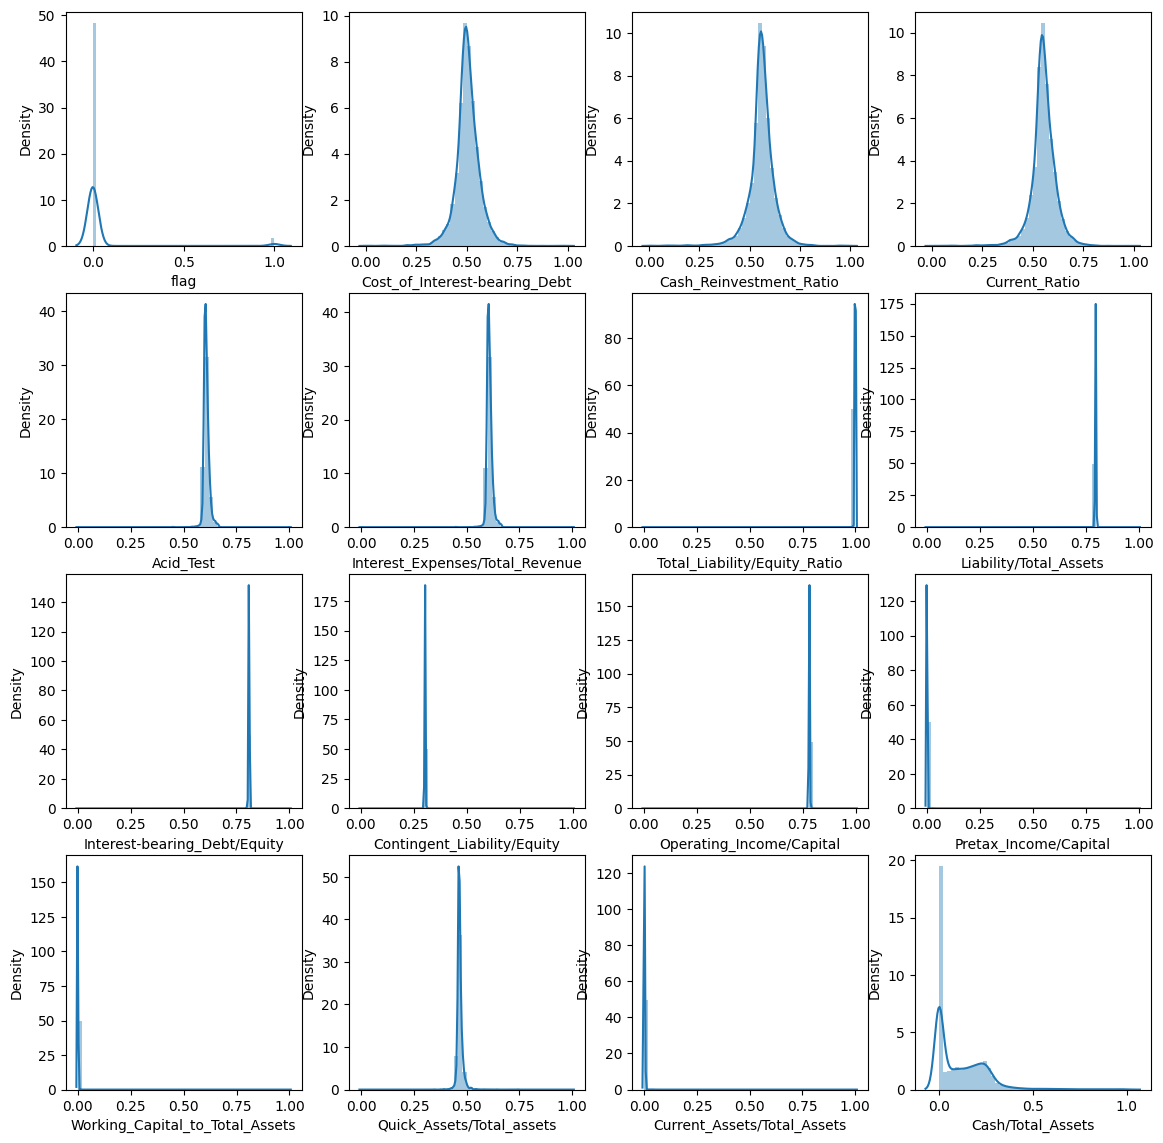

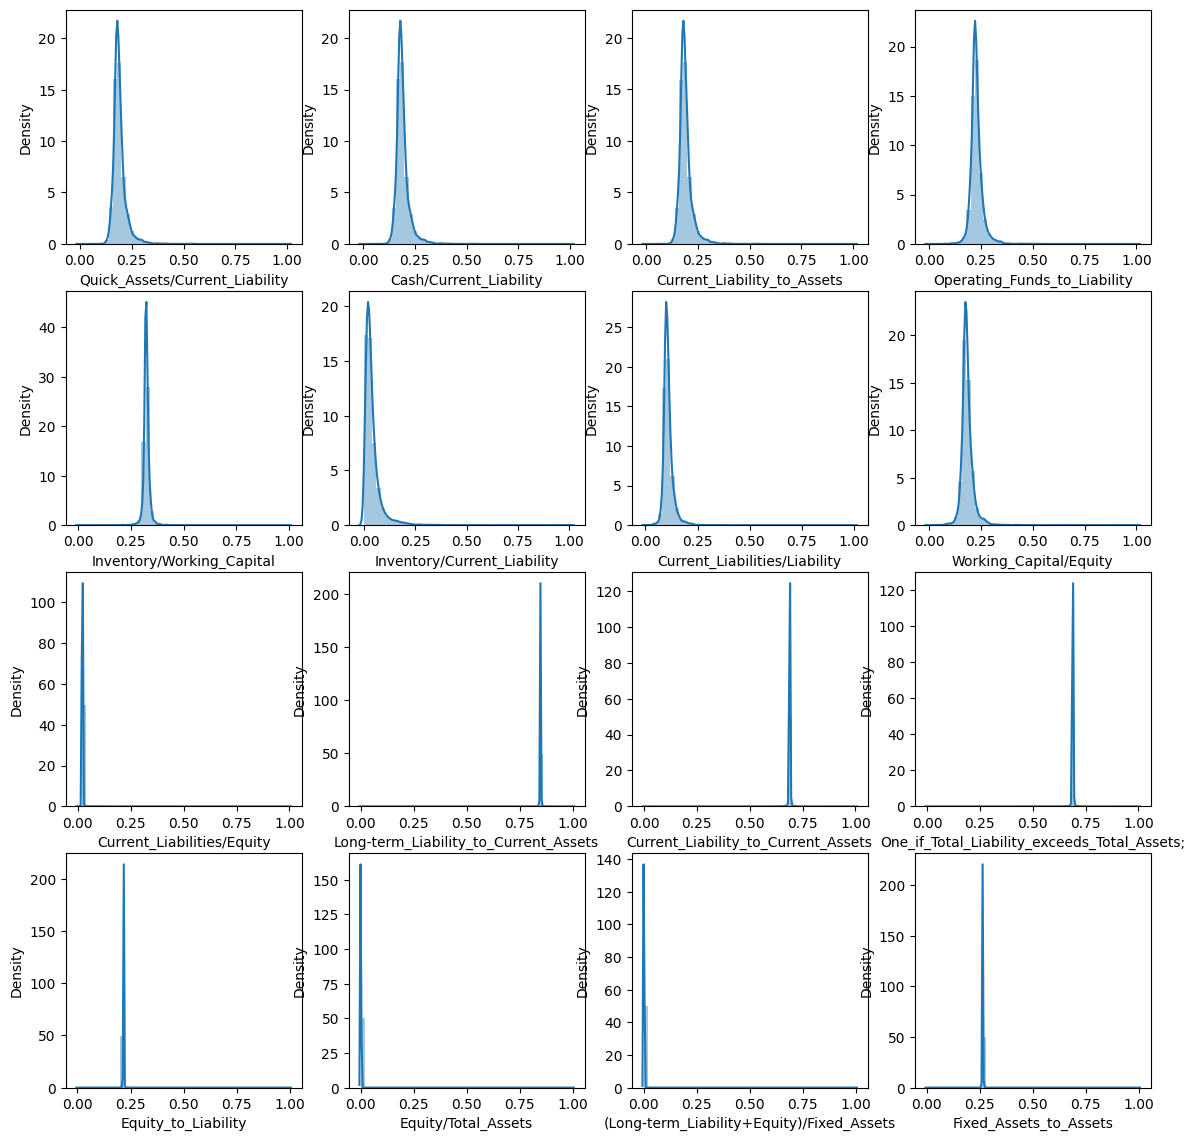

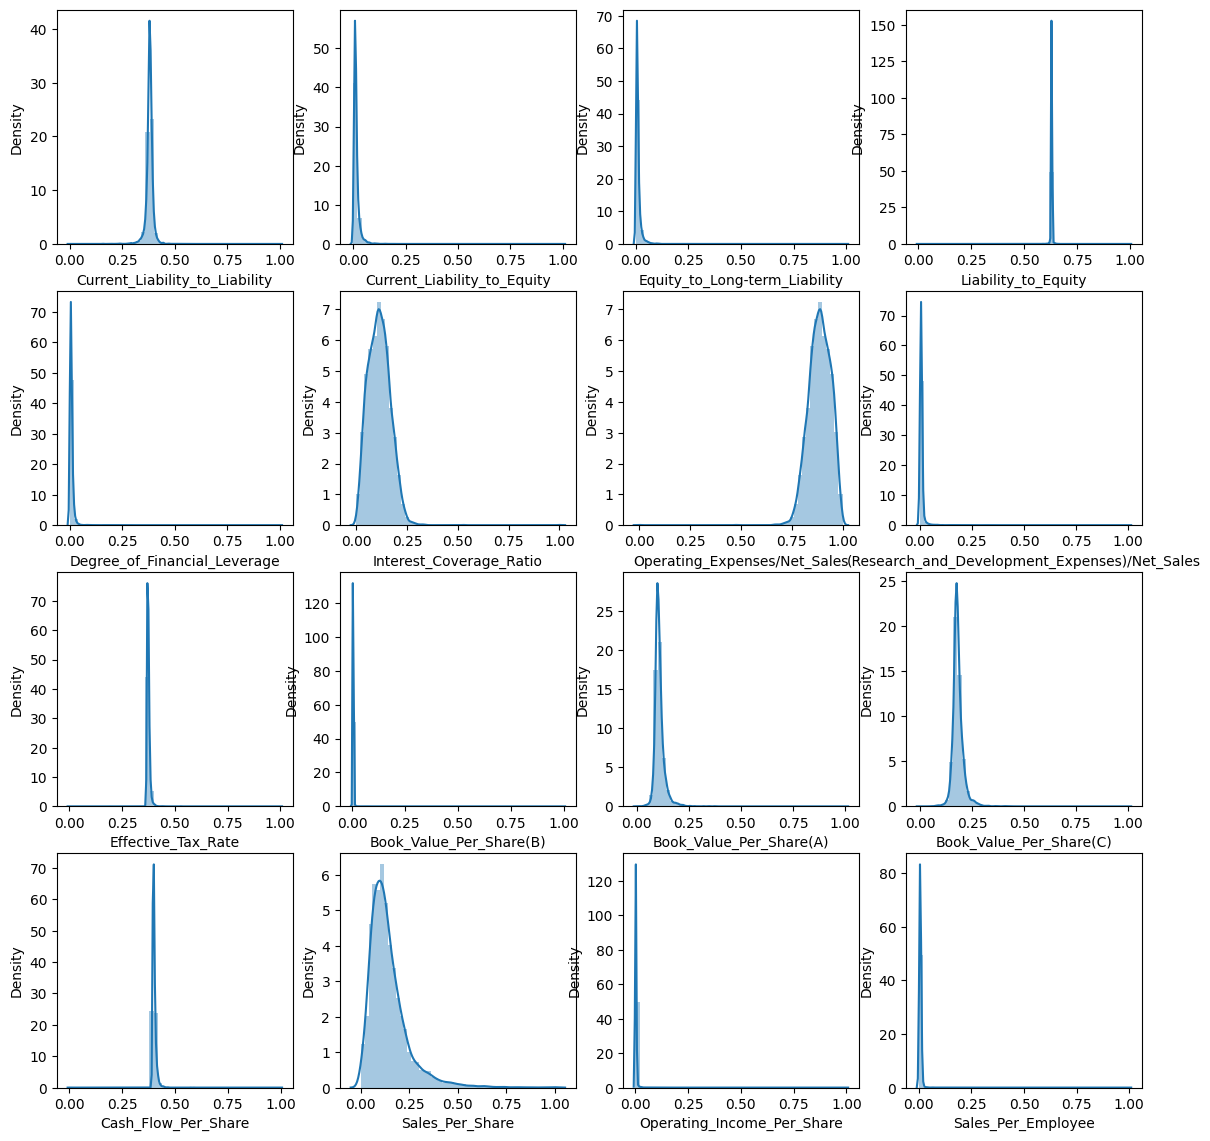

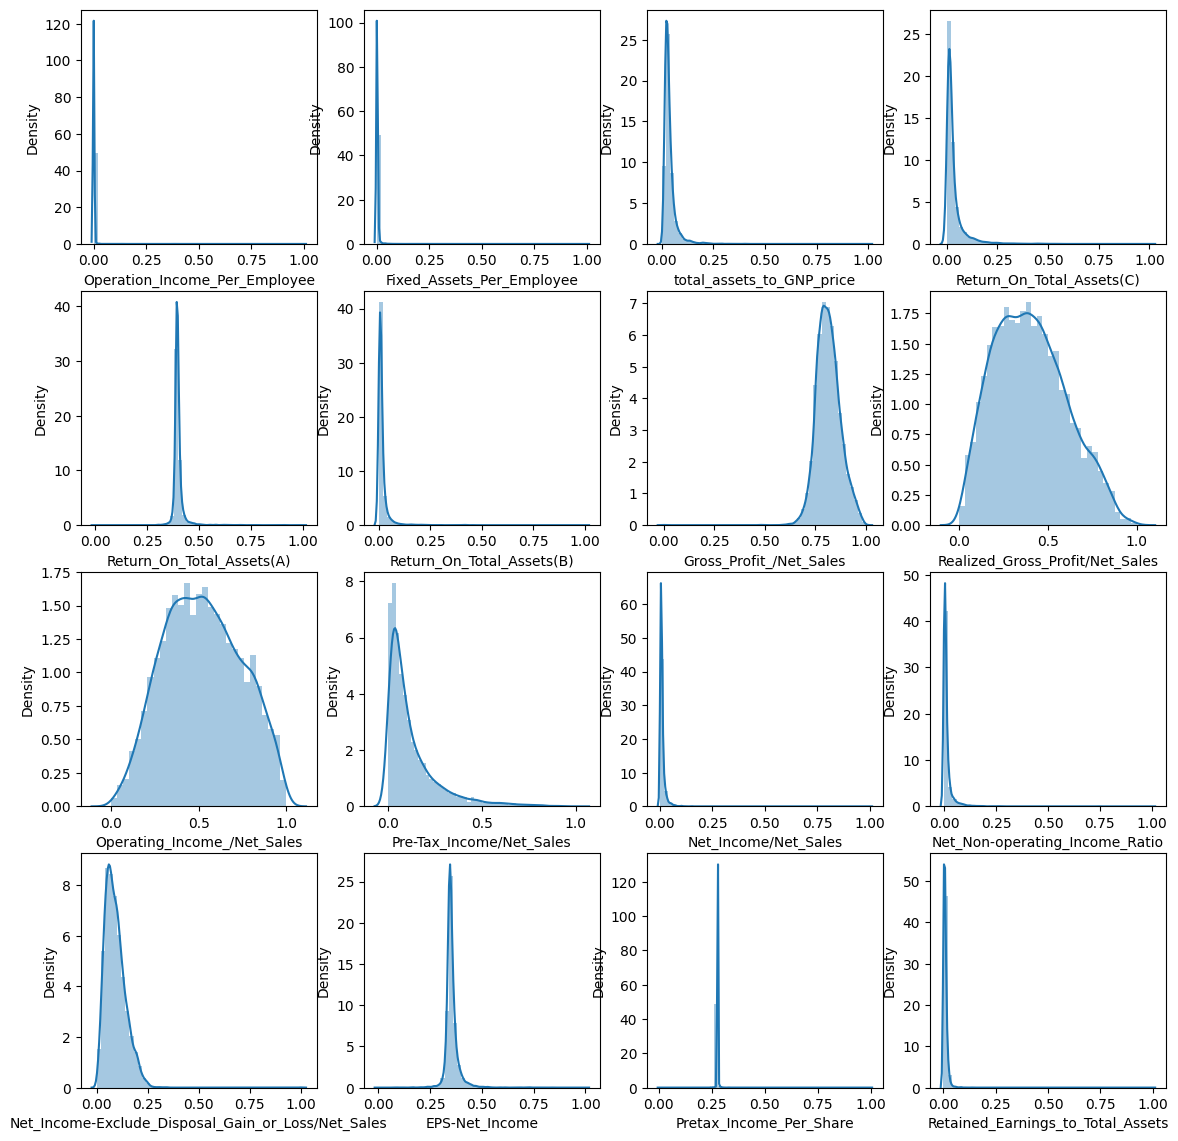

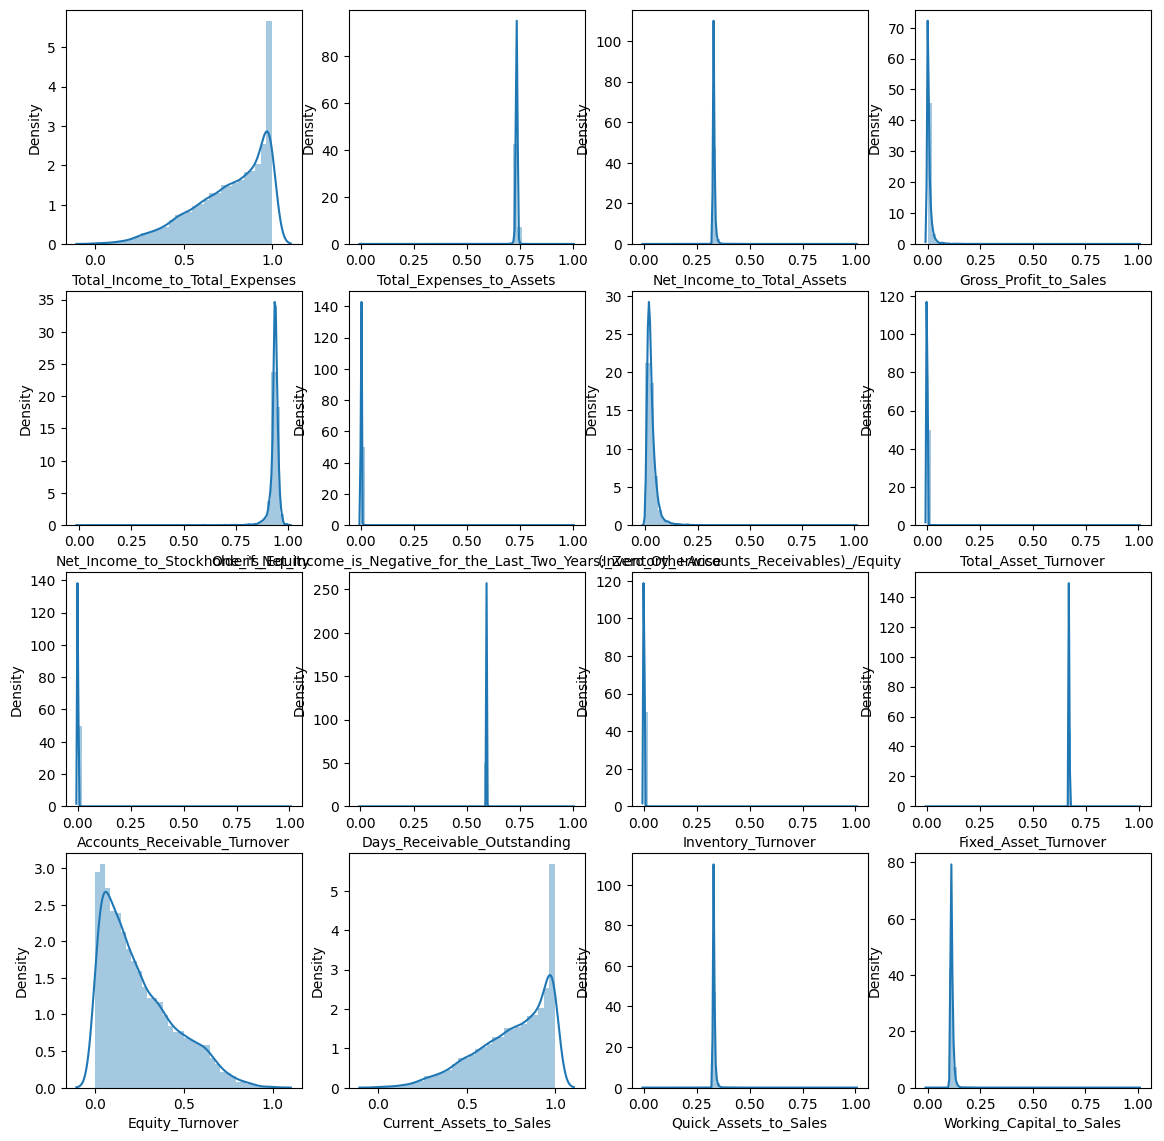

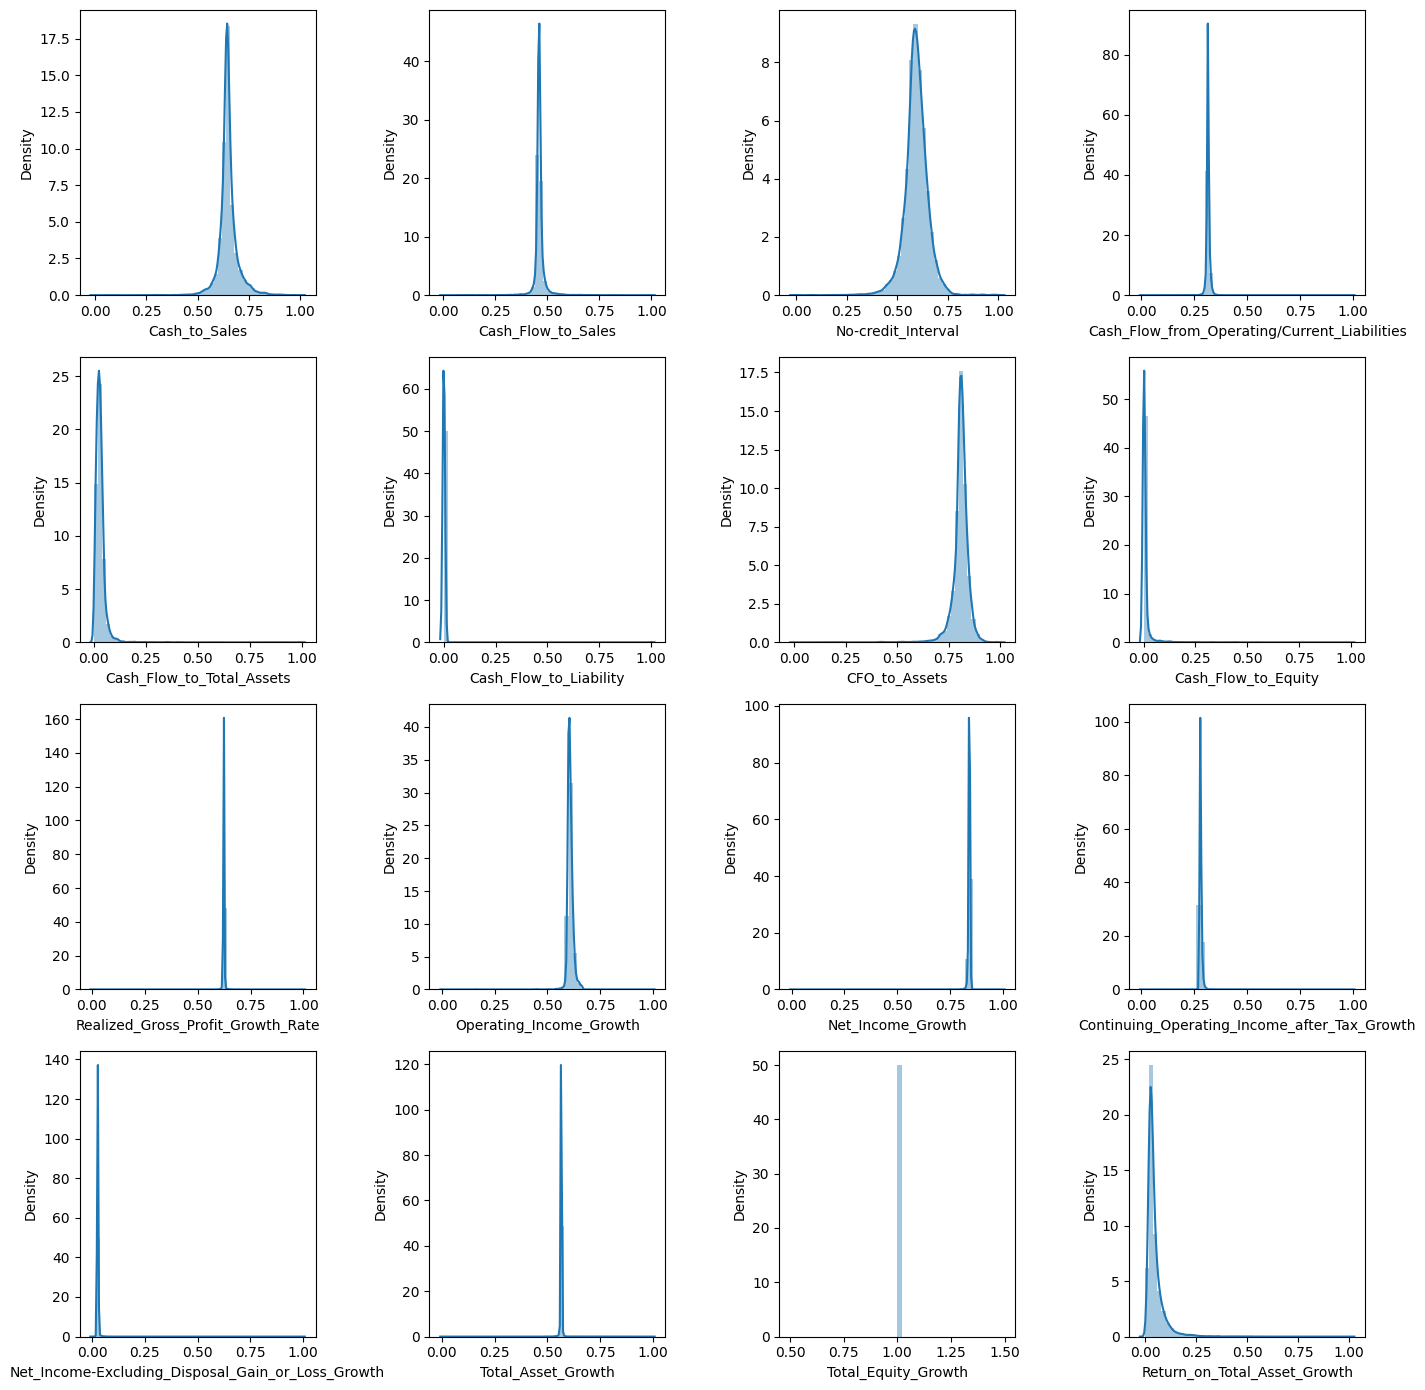

In [ ]:
width = 14
height = 14

plt.style.use("default")


figures = np.array([None]*6)
axes = np.array([None]*6)
for i in range(6):
  figures[i], axes[i] = plt.subplots(nrows=4, ncols=4, figsize=(width, height))

k = 0
columns = df.columns
for i in range(6):
  for axe in axes[i].flatten():
    sns.distplot(df[columns[k]], ax=axe)
    k = k + 1
  plt.tight_layout()
  save_figure(figures[i],'.','distri_{}_{}.pdf'.format(i*16,(i+1)*16))

**Correlation**

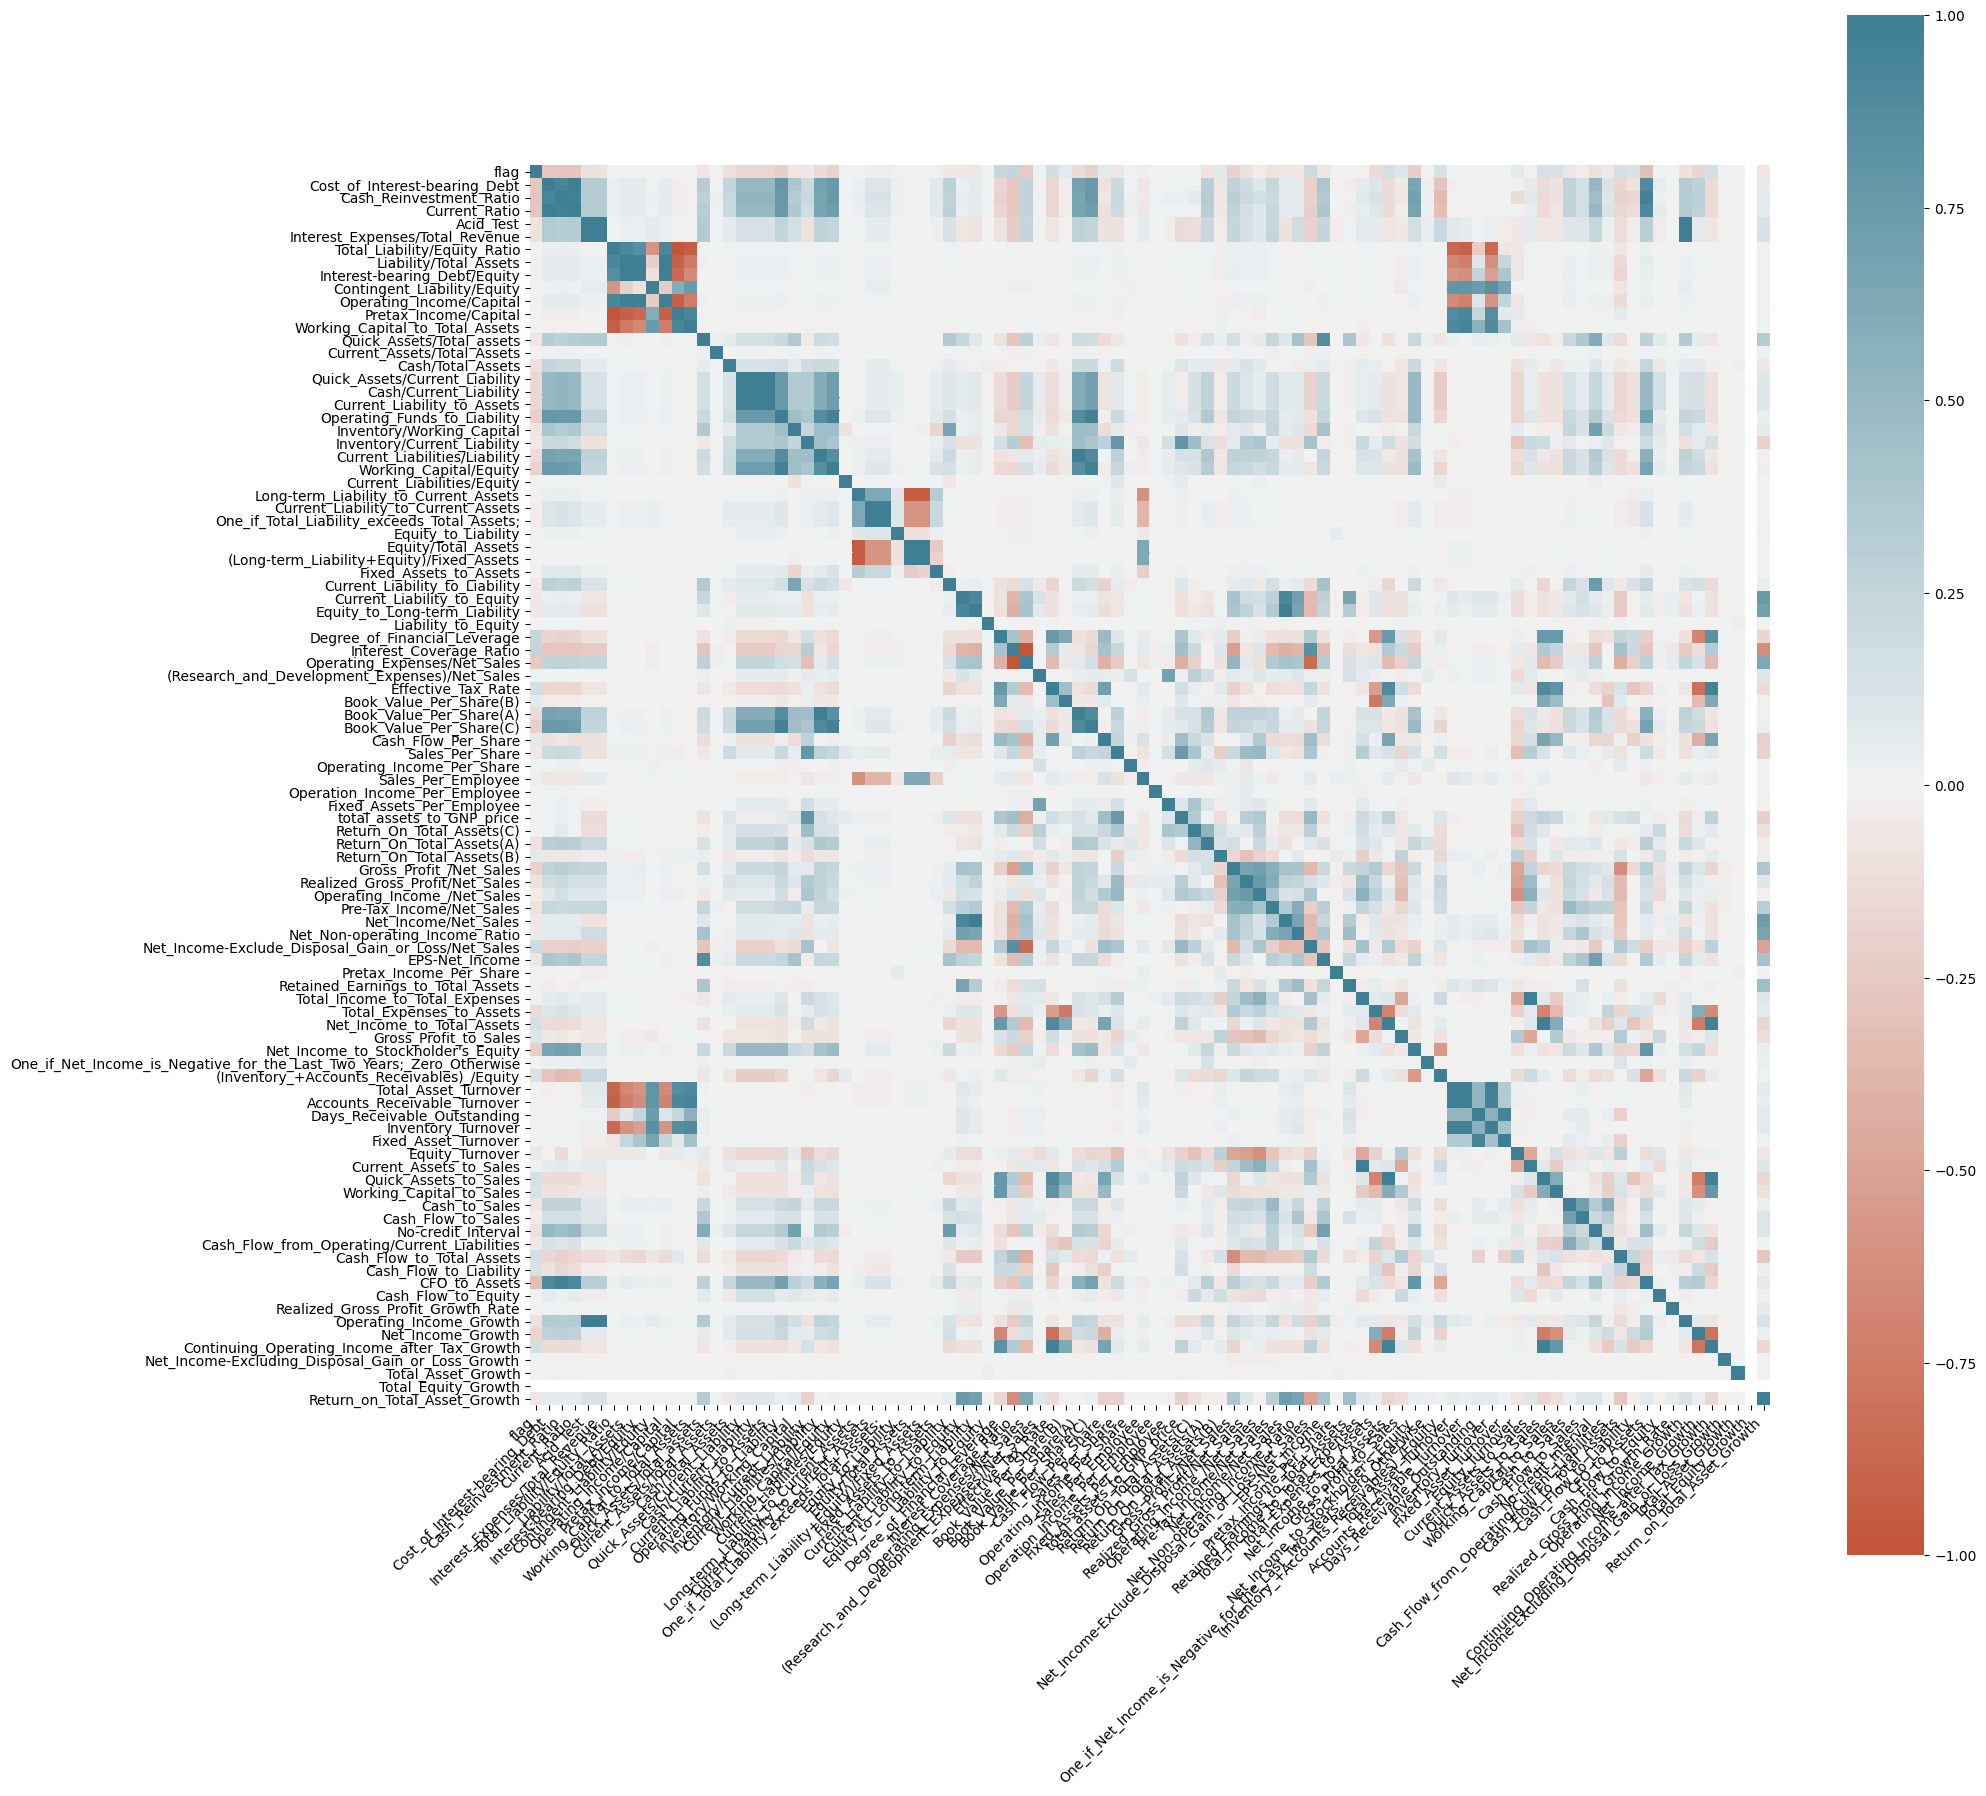

In [ ]:
corr = df.corr()
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    yticklabels=list(df.columns),
    xticklabels=list(df.columns),
    square=True,
    ax = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
save_figure(fig,'.','correlations.pdf')

**Dataframe characteristics**


In [ ]:
df.describe() # Total equity grown is always 1

,flag,Cost_of_Interest-bearing_Debt,Cash_Reinvestment_Ratio,Current_Ratio,Acid_Test,Interest_Expenses/Total_Revenue,Total_Liability/Equity_Ratio,Liability/Total_Assets,Interest-bearing_Debt/Equity,Contingent_Liability/Equity,Operating_Income/Capital,Pretax_Income/Capital,Working_Capital_to_Total_Assets,Quick_Assets/Total_assets,Current_Assets/Total_Assets,Cash/Total_Assets,Quick_Assets/Current_Liability,Cash/Current_Liability,Current_Liability_to_Assets,Operating_Funds_to_Liability,Inventory/Working_Capital,Inventory/Current_Liability,Current_Liabilities/Liability,Working_Capital/Equity,Current_Liabilities/Equity,Long-term_Liability_to_Current_Assets,Current_Liability_to_Current_Assets,One_if_Total_Liability_exceeds_Total_Assets;,Equity_to_Liability,Equity/Total_Assets,(Long-term_Liability+Equity)/Fixed_Assets,Fixed_Assets_to_Assets,Current_Liability_to_Liability,Current_Liability_to_Equity,Equity_to_Long-term_Liability,Liability_to_Equity,Degree_of_Financial_Leverage,Interest_Coverage_Ratio,Operating_Expenses/Net_Sales,(Research_and_Development_Expenses)/Net_Sales,...,Operating_Income_/Net_Sales,Pre-Tax_Income/Net_Sales,Net_Income/Net_Sales,Net_Non-operating_Income_Ratio,Net_Income-Exclude_Disposal_Gain_or_Loss/Net_Sales,EPS-Net_Income,Pretax_Income_Per_Share,Retained_Earnings_to_Total_Assets,Total_Income_to_Total_Expenses,Total_Expenses_to_Assets,Net_Income_to_Total_Assets,Gross_Profit_to_Sales,Net_Income_to_Stockholder's_Equity,One_if_Net_Income_is_Negative_for_the_Last_Two_Years;_Zero_Otherwise,(Inventory_+Accounts_Receivables)_/Equity,Total_Asset_Turnover,Accounts_Receivable_Turnover,Days_Receivable_Outstanding,Inventory_Turnover,Fixed_Asset_Turnover,Equity_Turnover,Current_Assets_to_Sales,Quick_Assets_to_Sales,Working_Capital_to_Sales,Cash_to_Sales,Cash_Flow_to_Sales,No-credit_Interval,Cash_Flow_from_Operating/Current_Liabilities,Cash_Flow_to_Total_Assets,Cash_Flow_to_Liability,CFO_to_Assets,Cash_Flow_to_Equity,Realized_Gross_Profit_Growth_Rate,Operating_Income_Growth,Net_Income_Growth,Continuing_Operating_Income_after_Tax_Growth,Net_Income-Excluding_Disposal_Gain_or_Loss_Growth,Total_Asset_Growth,Total_Equity_Growth,Return_on_Total_Asset_Growth
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,0.000444,0.000244,0.467431,0.000826,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,0.038964,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,0.000239,0.000688,0.264248,0.379677,0.015104,0.011062,0.630991,0.007997,0.113177,0.886823,0.008783,...,0.522273,0.124095,0.011759,0.013096,0.090673,0.353828,0.277395,0.008989,0.761599,0.735817,0.331410,0.007137,0.934733,0.002549,0.029184,0.000546,0.000427,0.594006,0.000438,0.671531,0.249353,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,0.807760,0.008639,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,0.012679,0.013021,0.012119,

**Class count**

In [ ]:
df['flag'].value_counts()

0    6599
1     220
Name: flag, dtype: int64

## Preprocessing

In [ ]:
# Change column names for easier coding : x1 to x64 attributes/columns and Y as label column that states company is bankrupt or not
df_bankruptcy = df.rename(columns=names_to_codes,inplace=False)
df_bankruptcy.head(5)

,flag,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,0.000126,0.000000,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,0.000050,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,0.000147,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,0.000070,0.000066,0.593831,0.000005,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,0.000290,0.000000,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,0.000061,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,0.001384,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,0.000107,0.000077,0.593916,0.000025,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,0.000236,0.000003,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,0.000073,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,...,0.602806,0.000991,0.006302,0.000053,0.098162,0.336731,0.277456,0.013879,0.446027,0.742729,0.334777,0.003715,0.909903,0.002060,0.021387,0.001791,0.001023,0.594502,0.000008,0.671571,0.276179,0.446027,0.334777,0.117922,0.642765,0.459254,0.538491,0.314515,0.025346,0,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,0.000108,0.000000,0.465705,0.000449,0.0,0.154187,0.154187,0.154187,0.193722,0.321674,0.014368,0.077762,0.148603,0.022046,0.848005,0.689110,0.689110,0.217568,0.000049,0.000382,0.263371,0.384077,0.004194,0.002896,0.630228,0.009572,0.151465,0.848535,0.005047,...,0.225815,0.018851,0.002961,0.001011,0.098715,0.348716,0.276580,0.003540,0.615848,0.729825,0.331509,0.022165,0.906902,0.001831,0.024161,0.000081,0.000061,0.593889,0.000020,0.671519,0.559144,0.615848,0.331509,0.120760,0.579039,0.448518,0.604105,0.302382,0.067250,0,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,0.000079,0.000000,0.462746,0.000686,0.0,0.167502,0.167502,0.167502,0.212537,0.319162,0.029690,0.096898,0.168412,0.022096,0.848258,0.689697,0.689697,0.217626,0.000055,0.000439,0.265218,0.379690,0.006022,0.003727,0.636055,0.005150,0.106509,0.893491,0.005303,...,0.358380,0.014161,0.004275,0.000680,0.110195,0.344639,0.287913,0.004869,0.975007,0.732000,0.330726,0.000000,0.913850,0.002224,0.026385,0.000067,0.000051,0.593915,0.000008,0.671563,0.309555,0.975007,0.330726,0.110933,0.622374,0.454411,0.578469,0.311567,0.047725,0,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [ ]:
df_bankruptcy.dtypes # X94 will be considered although it seems not important

flag      int64
X1      float64
X2      float64
X3      float64
X4      float64
         ...   
X91     float64
X92     float64
X93     float64
X94       int64
X95     float64
Length: 96, dtype: object

In [ ]:
def convert_datatype(df):
    index = 1
    while (index <= 95):
        colname = df.columns[index]
        col = getattr(df, colname)
        df[colname] = col.astype(float)
        index += 1


convert_datatype(df_bankruptcy)

In [ ]:
# Converting label column to 0 or 1
def labels_to_binary(df):
    col = getattr(df, 'flag')
    df['flag'] = col.astype(int)

labels_to_binary(df_bankruptcy)

In [ ]:
def drop_nans(df_bankruptcy, verbose=False):
    clean_dataframes = df_bankruptcy.dropna(axis=0, how='any')
    return clean_dataframes

nan_dropped_df = drop_nans(df_bankruptcy, verbose=True)

In [ ]:
def mean_imputation(df):
    # Construct an imputer with strategy as 'mean', to mean-impute along the columns
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    mean_imputed_df = pd.DataFrame(imputer.fit_transform(df))
    mean_imputed_df.columns = df.columns
    return mean_imputed_df

mean_imputed_df = mean_imputation(df_bankruptcy)

In [ ]:
imputed_dict = OrderedDict()
imputed_dict['Mean'] = mean_imputed_df
print(mean_imputed_df.head(5))

   flag        X1        X2        X3  ...       X92       X93  X94       X95
0   1.0  0.370594  0.424389  0.405750  ...  0.026601  0.564050  1.0  0.016469
1   1.0  0.464291  0.538214  0.516730  ...  0.264577  0.570175  1.0  0.020794
2   1.0  0.426071  0.499019  0.472295  ...  0.026555  0.563706  1.0  0.016474
3   1.0  0.399844  0.451265  0.457733  ...  0.026697  0.564663  1.0  0.023982
4   1.0  0.465022  0.538432  0.522298  ...  0.024752  0.575617  1.0  0.035490

[5 rows x 96 columns]


In [ ]:
# Splitting features and labels
def split_features_labels(df):
    feature_dfs = df.iloc[:, 1:]
    label_dfs = df['flag']
    return feature_dfs, label_dfs

In [ ]:
# K-Fold Cross Validation
def kfold_cv(k, X, y, verbose=False):
    X = X.values  # Features
    y = y.values  # Labels
    kf = KFold(n_splits=k, shuffle=False, random_state=42)
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for train_index, test_index in kf.split(X):
        X_train.append(X[train_index])
        y_train.append(y[train_index])
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    return X_train, y_train, X_test, y_test


seed = 7

In [ ]:
# Extreme Abda Boosting Classifier
ada_boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=seed), n_estimators=5, random_state=seed)

# Bagging Classifier
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=seed), n_estimators=5, random_state=seed)

# Neural Network Classifier - Multi layer perceptron
mlp = MLPClassifier(hidden_layer_sizes=(12, 12, 12), random_state=seed)

# Building dictionary to enable calling the following classifiers and save their results as values
models_dictionary = OrderedDict()
models_dictionary['AdaBoost'] = ada_boost
models_dictionary['Bagging Tree'] = bagging
models_dictionary['Neural Network'] = mlp

------------------------------------------------------------------------------------------------------------------------ 
 Model: AdaBoost Classifier
		Dataset: 1year
[[1254   37]
 [  44   29]]
[[1178   61]
 [  94   31]]
[[1311   14]
 [  32    7]]
[[1317   14]
 [  28    5]]
[[1322   12]
 [  19   10]]
			Accuracy: 0.9479438791866313
			Precision: [0.97840537 0.26421804]
			Recall: [0.96667774 0.36547743]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Bagging Tree Classifier
		Dataset: 1year
[[1284   44]
 [  14   22]]
[[1193   70]
 [  79   22]]
[[1328   16]
 [  15    5]]
[[1331   16]
 [  14    3]]
[[1335   15]
 [   6    7]]
			Accuracy: 0.9576223743123133
			Precision: [0.97530995 0.358773  ]
			Recall: [0.98021101 0.25732711]
------------------------------------------------------------------------------------------------------------------------ 
 Model: Neural Network Classifier
		Dataset: 1year
[[1297   

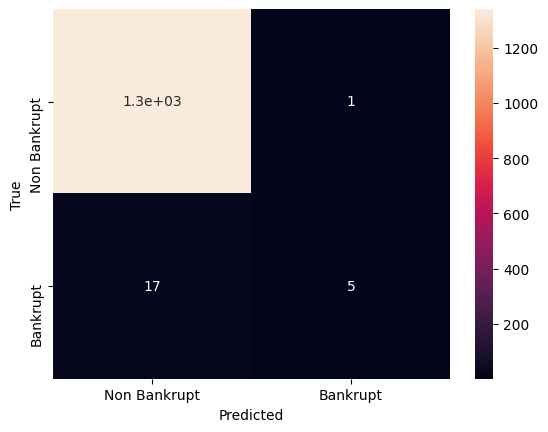

In [ ]:
def perform_data_modeling(_models_, imputed_df, verbose=False, k_folds=5):
    # 7 metrics, averaged over all the K-Folds
    model_results = OrderedDict()

    # Iterate over classifiers
    for model_name, clf in _models_.items():
        if verbose: print("-" * 120, "\n", "Model: " + '\033[1m' + model_name + '\033[0m' + " Classifier")
        imputer_results = OrderedDict()

        # Mean imputation is in a dictionary and iterating over that.In our case, only mean_imputation is implemented
        features_df, labels_df = split_features_labels(imputed_df)

        years = OrderedDict()
        df_index = 0
        if verbose: print('\t\tDataset: ' + '\033[1m' + str(df_index + 1) + 'year' + '\033[0m')
        # Running K-fold cross validation on train and test set
        X_train_list, y_train_list, X_test_list, y_test_list = kfold_cv(k_folds, features_df,
                                                                        labels_df, verbose)

        metrics = OrderedDict()

        # Calculating accuracy, precision, recall, and confusion matrix
        # Initializing these variables with a numpy array of 0

        accuracy_list = np.zeros([k_folds])
        precision_list = np.zeros([k_folds, 2])
        recall_list = np.zeros([k_folds, 2])
        true_negs = np.zeros([k_folds])
        false_pos = np.zeros([k_folds])
        false_negs = np.zeros([k_folds])
        true_pos = np.zeros([k_folds])

        # Iterate over all the k-folds and calculate accuracy, precision and confusion matrix
        for k in range(k_folds):
            X_train = X_train_list[k]
            y_train = y_train_list[k]
            X_test = X_test_list[k]
            y_test = y_test_list[k]

            # Fit the model and call predict function for test set
            clf = clf.fit(X_train, y_train)

            y_test_predicted = clf.predict(X_test)
            print(confusion_matrix(y_test_predicted, y_test))

            _accuracy_ = accuracy_score(y_test, y_test_predicted, normalize=True)
            accuracy_list[k] = _accuracy_
            _recalls_ = recall_score(y_test, y_test_predicted, average=None)
            recall_list[k] = _recalls_

            # code for calculating precision
            _precisions_ = precision_score(y_test, y_test_predicted, average=None)
            precision_list[k] = _precisions_

            # code for calculating confusion matrix
            _confusion_matrix_ = confusion_matrix(y_test, y_test_predicted)
            mlp_cm = confusion_matrix(y_test, y_test_predicted)

            true_negs[k] = _confusion_matrix_[0][0]
            false_pos[k] = _confusion_matrix_[0][1]
            false_negs[k] = _confusion_matrix_[1][0]
            true_pos[k] = _confusion_matrix_[1][1]

        metrics['Accuracy'] = np.mean(accuracy_list)
        metrics['Precisions'] = np.mean(precision_list, axis=0)
        metrics['Recalls'] = np.mean(recall_list, axis=0)
        metrics['TN'] = np.mean(true_negs)
        metrics['FP'] = np.mean(false_pos)
        metrics['FN'] = np.mean(false_negs)
        metrics['TP'] = np.mean(true_pos)

        if verbose:
            print('\t\t\tAccuracy:', metrics['Accuracy'])
            print('\t\t\tPrecision:', metrics['Precisions'])
            print('\t\t\tRecall:', metrics['Recalls'])

        model_results[model_name] = metrics

    sns.heatmap(mlp_cm, annot=True,
                xticklabels=['Non Bankrupt', 'Bankrupt'],
                yticklabels=['Non Bankrupt', 'Bankrupt'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return model_results

# ideally 5 fold cross validation yielded better results
results = perform_data_modeling(models_dictionary, mean_imputed_df, verbose=True, k_folds=5)


In [ ]:
def perform_model_ranking_acc(models, imputers, results):
    column_headers = ['-'] + list(imputers.keys())
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['Accuracy'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df
print(perform_model_ranking_acc(models_dictionary, imputed_dict, results))

                -      Mean
0        AdaBoost  0.947944
1    Bagging Tree  0.957622
2  Neural Network  0.967887


In [ ]:
def perform_model_ranking_acc(models, imputers, results):
    column_headers = ['-','Accuracy'] 
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['Accuracy'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df
print(perform_model_ranking_acc(models_dictionary, imputed_dict, results))

def perform_model_ranking_prec(models, imputers, results):
    column_headers = ['-','Precisions']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['Precisions'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df
print(perform_model_ranking_prec(models_dictionary, imputed_dict, results))

def perform_model_ranking_rec(models, imputers, results):
    column_headers = ['-','Recalls']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['Recalls'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df
print(perform_model_ranking_rec(models_dictionary, imputed_dict, results))

def perform_model_ranking_tn(models, imputers, results):
    column_headers = ['-','TN']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['TN'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df
print(perform_model_ranking_tn(models_dictionary, imputed_dict, results))

def perform_model_ranking_fp(models, imputers, results):
    column_headers = ['-','FP']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['FP'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df
print(perform_model_ranking_fp(models_dictionary, imputed_dict, results))

def perform_model_ranking_fn(models, imputers, results):
    column_headers = ['-','FN']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['FN'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df
print(perform_model_ranking_fn(models_dictionary, imputed_dict, results))

def perform_model_ranking_tp(models, imputers, results):
    column_headers = ['-','FP']
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        row.append(model_details['TP'])
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df
print(perform_model_ranking_tp(models_dictionary, imputed_dict, results))

                -  Accuracy
0        AdaBoost  0.947944
1    Bagging Tree  0.957622
2  Neural Network  0.967887
                -                                Precisions
0        AdaBoost   [0.9784053693310341, 0.264218038236366]
1    Bagging Tree  [0.9753099508578451, 0.3587730039972323]
2  Neural Network  [0.9722019547300734, 0.5395454545454546]
                -                                    Recalls
0        AdaBoost  [0.9666777393225783, 0.36547742874973993]
1    Bagging Tree   [0.9802110075960544, 0.2573271122470207]
2  Neural Network    [0.995071893705127, 0.1467913855785709]
                -      TN
0        AdaBoost  1276.4
1    Bagging Tree  1294.2
2  Neural Network  1313.4
                -    FP
0        AdaBoost  43.4
1    Bagging Tree  25.6
2  Neural Network   6.4
                -    FN
0        AdaBoost  27.6
1    Bagging Tree  32.2
2  Neural Network  37.4
                -    FP
0        AdaBoost  16.4
1    Bagging Tree  11.8
2  Neural Network   6.6
